# Project: Scan Matching Localization

This is the final project for the third course in the Udacity Self-Driving Car Engineer Nanodegree Program : Localization.<br>

In this project the goal was to localize a vehicle driving in carla simulatior for at least 170m from the starting position and never exceeding a distance pose error of 1.2m. The simulated car is equipped with a lidar, which provides scans at regular intervals.

The project environment including boiler plate code along with usage instruction were provided:<br>
https://github.com/udacity/nd0013_cd2693_Exercise_Starter_Code.git

## Setup project
The project has been setup as described in the github repository in file readme.md.<br>
Folder “libcarla-install” was deleted and rebuild using “make-libcarla-install.sh”, then the software has been build and exceuted without any code modifications.

The resulting lidar scan point cloud is upside down and rotated about the z-axis.

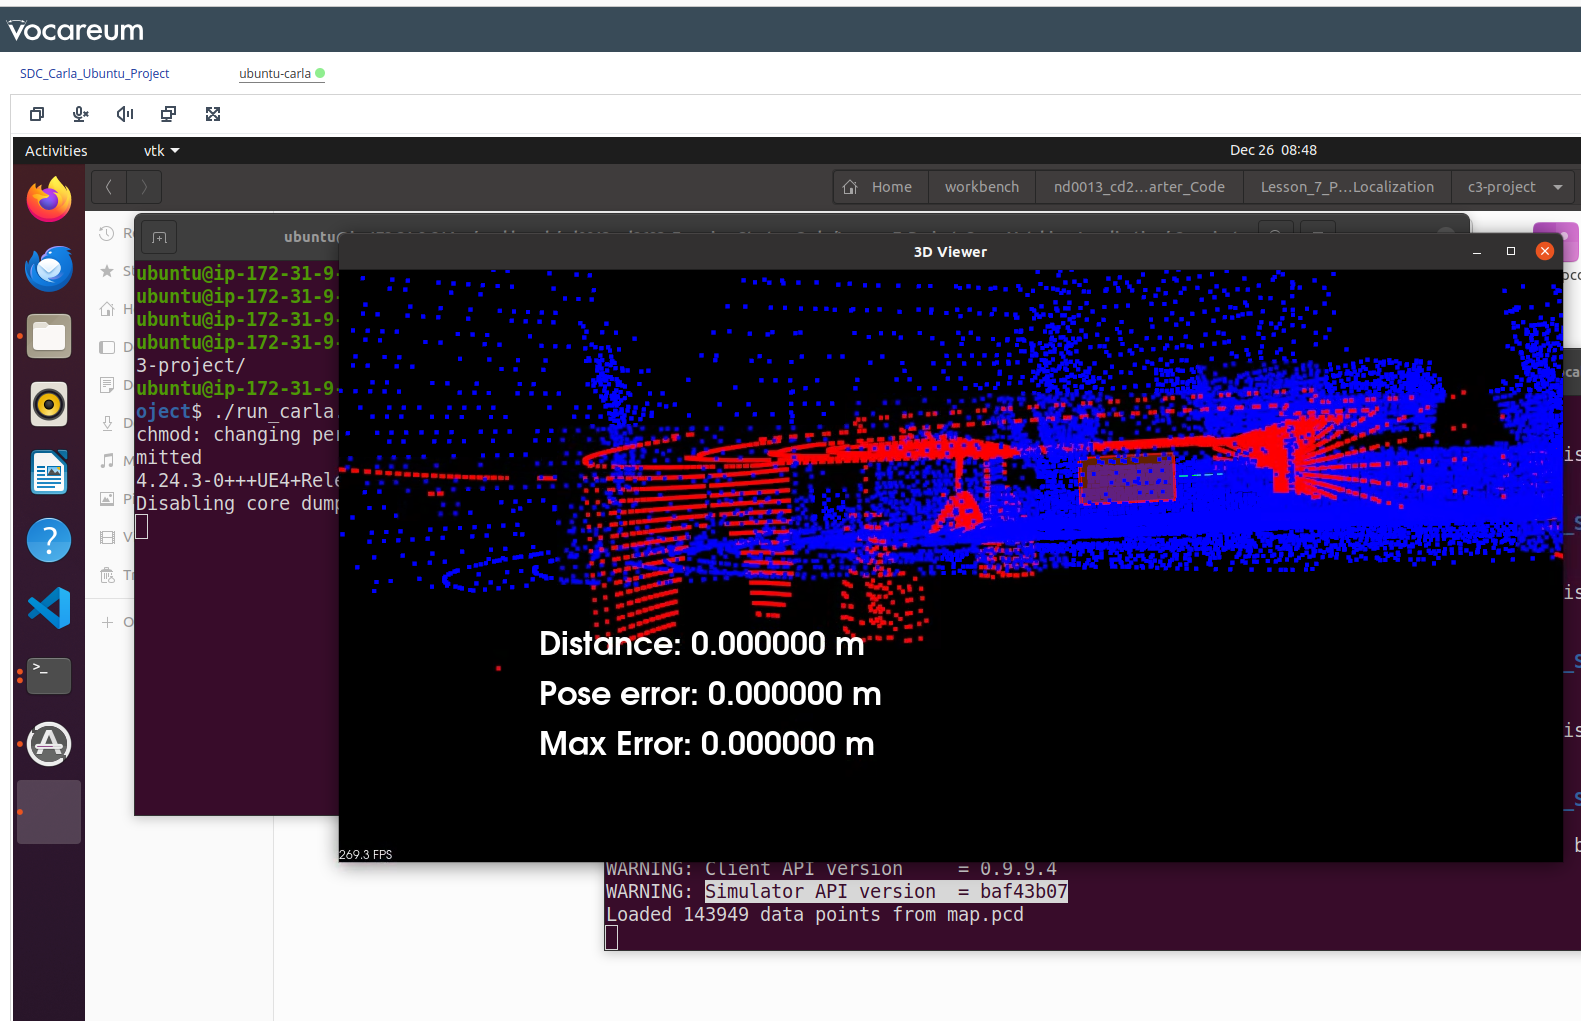

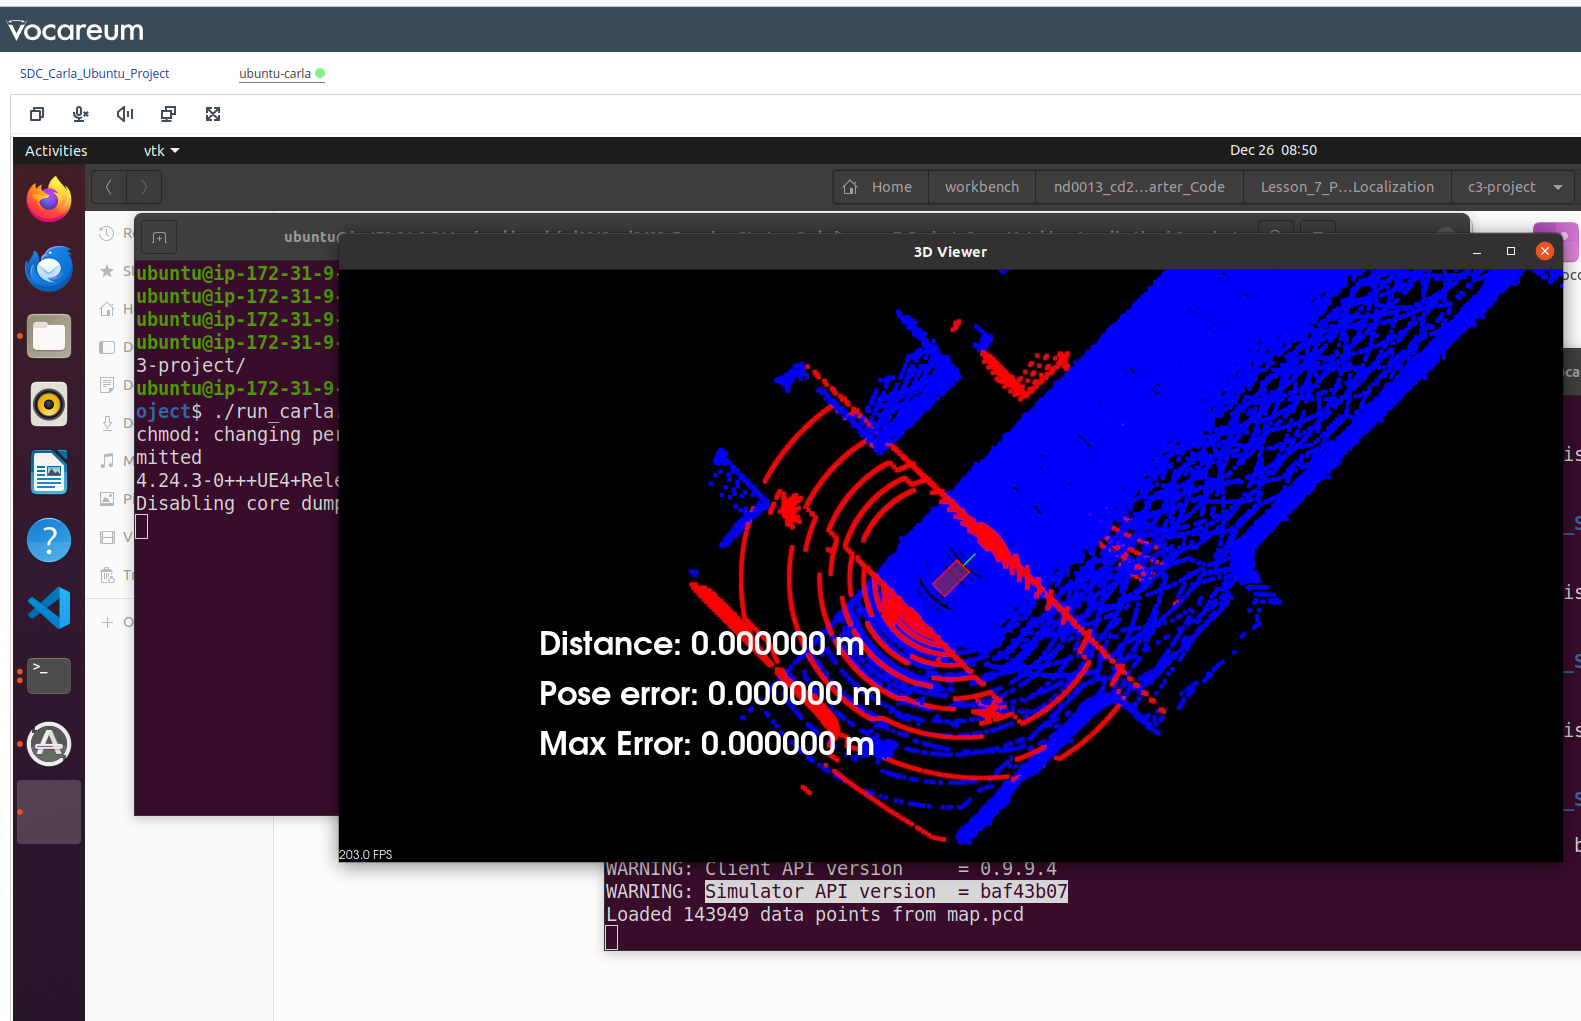

To correct this issue, the coordinates have been corrected inside the lidar Listen function.

## Step 2: Test and tune throttle controller

In [7]:
import matplotlib.pyplot as plt

In [31]:
t = []
error = []
throttle= []
brake = []
with open('throttle_pid_data.txt', 'r') as f:
    for line in f:
        data = line.split(' ')
        t.append(int(data[0]))        
        error.append(float(data[1]))
        brake.append(float(data[2]))
        throttle.append(float(data[3]))

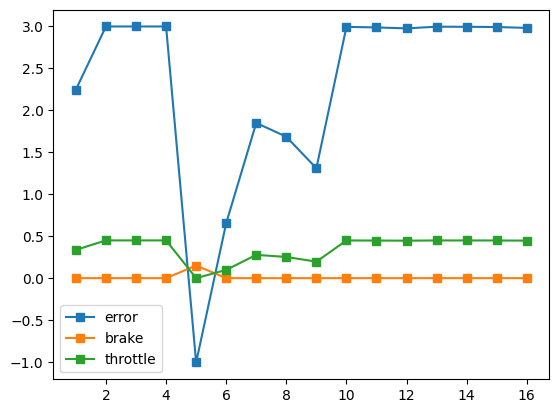

In [32]:
plt.plot(t, error, t, brake, t, throttle, linestyle=None, marker='s')
plt.legend(('error', 'brake', 'throttle'))

In [ ]:
t = []
error = []
steer = []
heading = []
yaw = []
x = []
y = []
x_pos = []
y_pos = []
dt = []
closest = []
speed = []

with open('steer_pid_data.txt', 'r') as f:
    for line in f:
        data = line.split(' ')
        t.append(int(data[0]))        
        error.append(float(data[1]))
        steer.append(float(data[2]))
        dt..append(float(data[3]))
        x.append(float(data[4]))
        y.append(float(data[5]))
        x_pos.append(float(data[6]))
        y_pos.append(float(data[7]))
        heading.append(float(data[8]))
        yaw.append(float(data[9]))
        closest.append(float(data[9]))
        speed.append(float(data[9]))
        

In [ ]:
plt.plot(t, error, t, steer, linestyle=None, marker='s')
plt.legend(('error', 'steer'))

In [ ]:
plt.plot(t, heading, t, yaw, linestyle=None, marker='s')
plt.legend(('heading', 'yaw'))

In [ ]:
plt.plot(t, speed, marker='s')

In [ ]:
plt.plot(x, y, linestyle='None', marker='x')
plt.plot(x_pos, y_pos, linestyle='None', marker='x')

In [ ]:
plt.plot(t, dt, marker='s')

74.305	7.61154	65.5166	7.80842

In [1]:
import numpy as np

In [19]:
def RotMatrix(theta, x, y):
    return np.matrix([[np.cos(theta), -np.sin(theta), x],
                      [np.sin(theta),  np.cos(theta), y],
                      [            0,              0, 1]])

In [33]:
point = np.matrix([[74.305], [7.61154], [1]])

In [34]:
np.linalg.inv(RotMatrix(0*np.pi/180, 65.5166, 7.80842)) * point

matrix([[ 8.7884 ],
        [-0.19688],
        [ 1.     ]])

In [32]:
np.linalg.inv(RotMatrix(0, 4.5, 4.5)) * point

matrix([[-3. ],
        [ 1.5],
        [ 1. ]])

In [25]:
import sympy as sy

In [28]:
x = sy.Symbol('x')
y = sy.Symbol('y')
theta = sy.Symbol('theta')

In [29]:
M = sy.matrices.Matrix([[sy.cos(theta), -sy.sin(theta), x],
                        [sy.sin(theta),  sy.cos(theta), y],
                        [            0,              0, 1]])

In [30]:
M

Matrix([
[cos(theta), -sin(theta), x],
[sin(theta),  cos(theta), y],
[         0,           0, 1]])

In [31]:
M.inv()

Matrix([
[-sin(theta)**2/cos(theta) + 1/cos(theta), sin(theta), (x*sin(theta)**2 - x - y*sin(theta)*cos(theta))/cos(theta)],
[                             -sin(theta), cos(theta),                                x*sin(theta) - y*cos(theta)],
[                                       0,          0,                                                          1]])

## Implementation of Scan Matching Localization
For scan matching localiaztion, the Iterative Closest Point algorithm (ICP) is used. The implementation is basically carried over from the exercises with no significant modification.

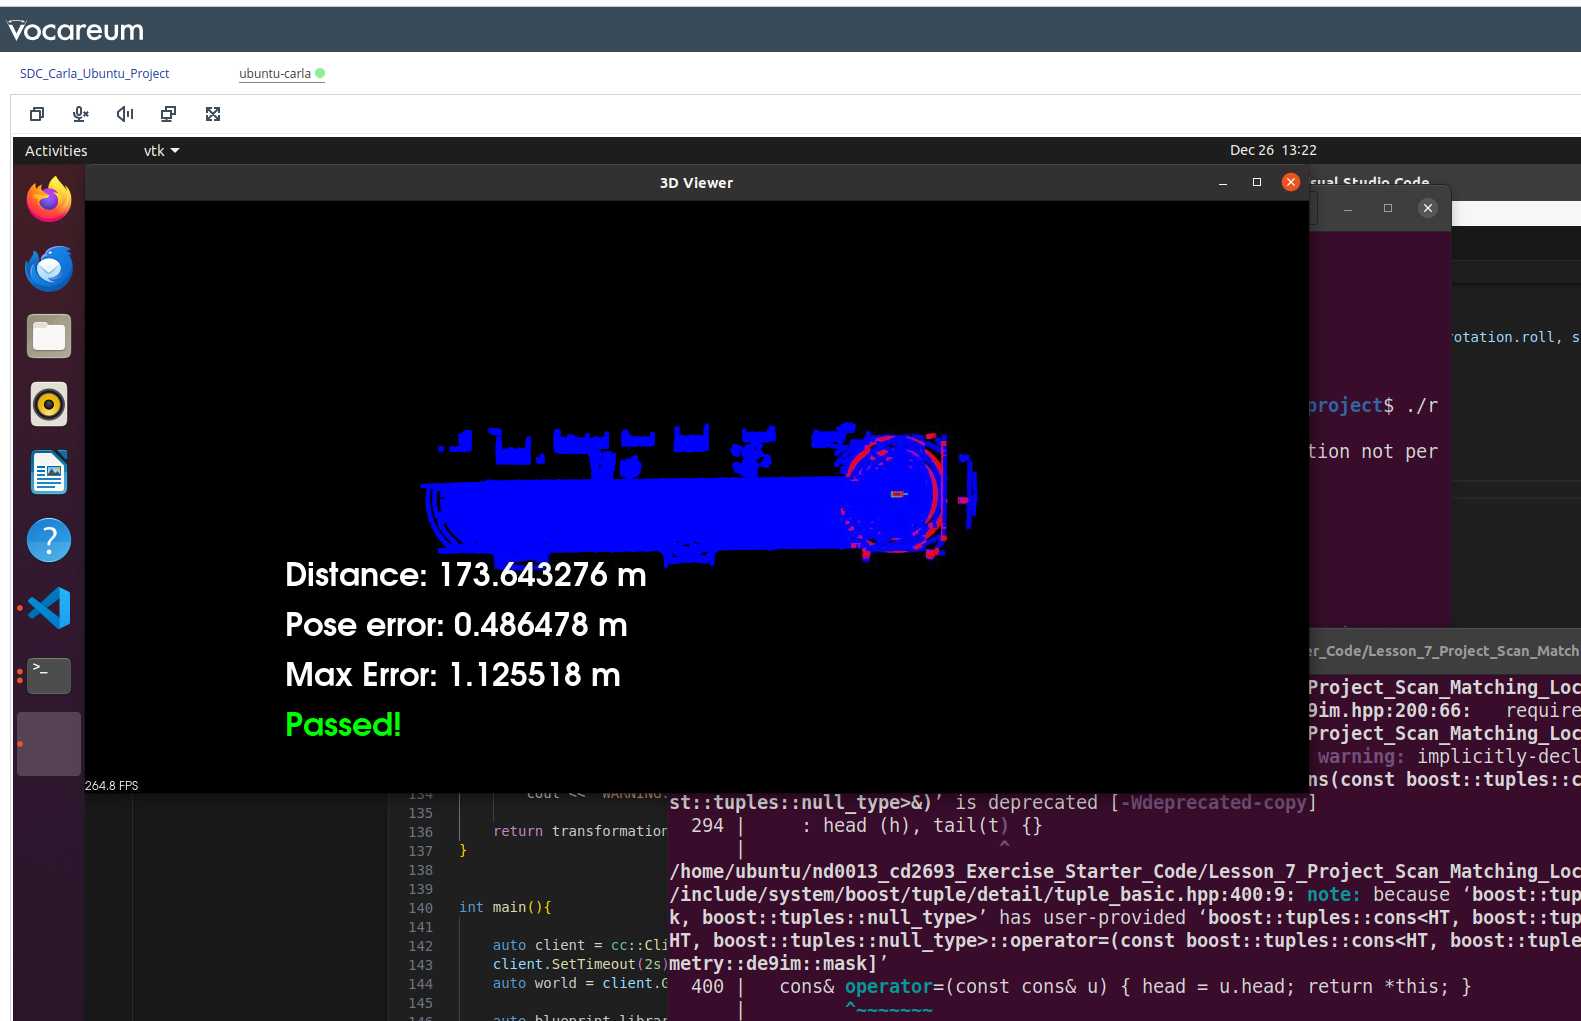

The results looked promising with 2 taps on the up arrow.

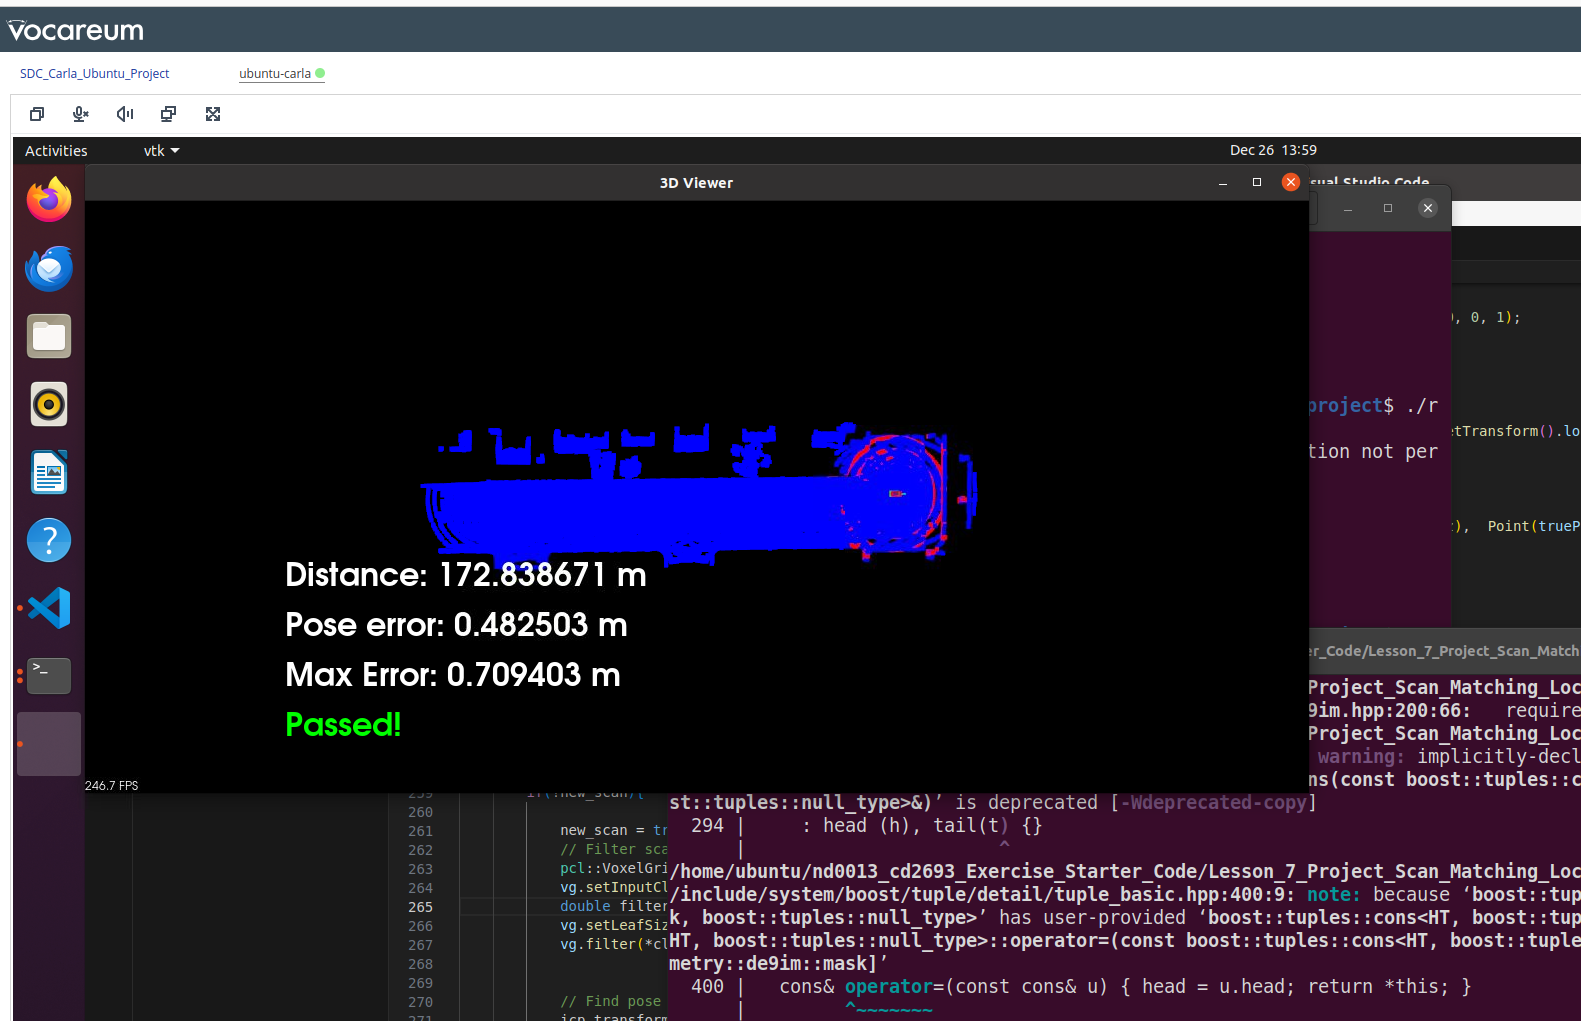

After tuning the hyperparameters:<br>
ICP MaxCorrespondenceDistance = 3 m<br>
Input Scan cloud voxel filter leaf size = 1 m<br>
Number of ICP interations: 15<br>
the results was even better, but still with 2 taps on the up arrow.<br>

With more than 2 taps on the arrow key, the Max Error was beyond the limit of 1.2 m.<br>
It was decided to add a linear Kalman filter to estimate the vehicle position and correct the estimation of the ICP position measurement.

## Addition of Kalman filter

The states have been chosen to
$$x = \begin{pmatrix}
x\\
y\\
\dot{x}\\
\dot{y}\\
\ddot{x}\\
\ddot{y}
\end{pmatrix}$$

With a constant acceleration model this resuls in the following state transition matrix:
$$F = \begin{pmatrix}
1 & 0 & dt & 0 & 0 & 0\\
0 & 1 & 0 & dt & 0 & 0\\
0 & 0 & 1 & 0 & dt & 0\\
0 & 0 & 0 & 1 & 0 & dt\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix}$$

Only position x and y are taken from the ICP measurement, so the measurement matrix is:
$$H = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0
\end{pmatrix}$$

For the process noise it is assumed, that position and velocity prediction are correct, but acceleration prediction has uncertainty due to acceleration velocity model. The resulting Process noise covariance Q in disretized form is:
$$Q = \begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \frac{dt^3q}{3} & 0 & \frac{dt^2q}{2} & 0\\
0 & 0 & 0 & \frac{dt^3q}{3} & 0 & \frac{dt^2q}{2}\\
0 & 0 & \frac{dt^3q}{3} & 0 & dtq & 0\\
0 & 0 & 0 & \frac{dt^3q}{3} & 0 & dtq
\end{pmatrix}$$
<br>
The process noise q has been chosen to be
$$q = (1 \frac{m}{s^3})^2$$
<br>because only small changes in the acceleration are expected.

The measurement noise is assumend to have zero mean and a variance of 0.4 m resulting in the measurement noise covariance matrix Q:
$$Q = \begin{pmatrix}
0.4 & 0\\
0 & 0.4
\end{pmatrix}$$

When new lidar measurement data is available, the prediction step is done first. The pose is updated with the predicted x, y position and then passed to the ICP.
The ICP estimate is used as measurement for the update step, the pose is again updated with the position estimated by the Kalman filter and then passed on for plotting and for calculating the max error.

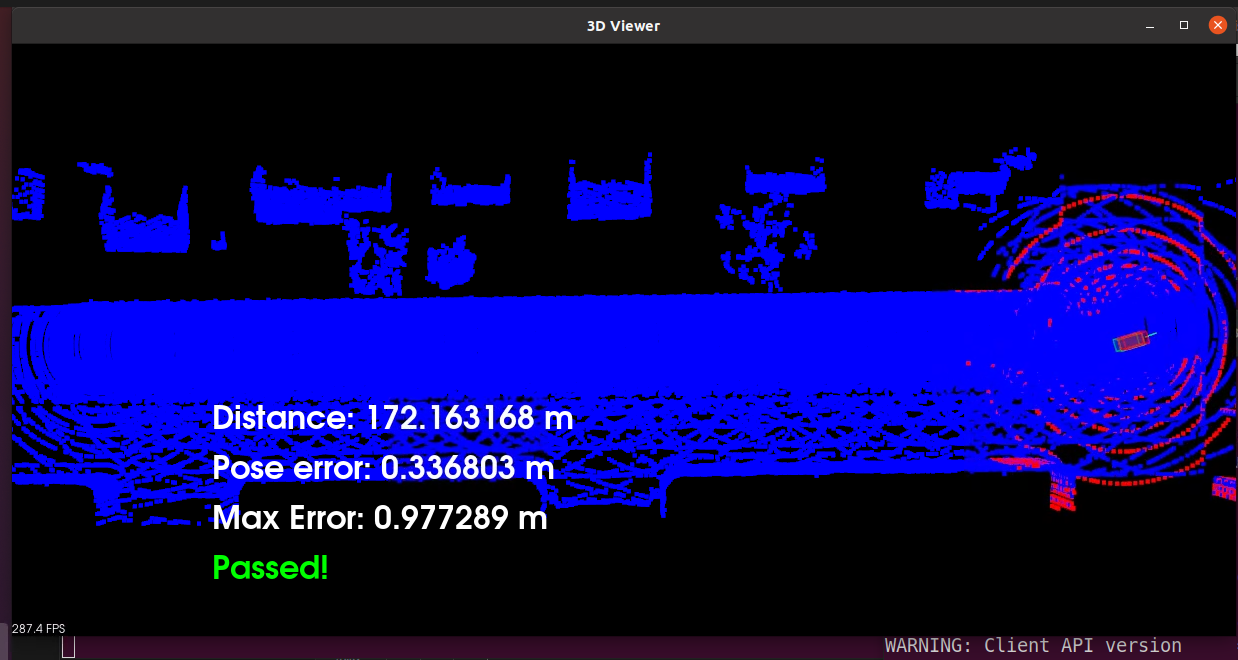

The resulting model can localize the vehicle with an max error less than 1.2 m, also at higher speeds.<br>
For a real world application, the model would need to be much more sofisticated:
- Take control input accerlation and steering into account
- Have the yaw angle and it's derivatives as state variables
  
Also, the scan matching algorithm could to be optimized for speed, so that it can be excuted at higher rate (e.g. once every full lidar revolution)